# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [2]:
# import libraries
from pyspark.sql import SparkSession
from pyspark.ml import Pipeline
import datetime
import numpy as np
import pandas as pd
from pyspark.sql import Window
import seaborn as sns
# TODOS: 
# 1) import any other libraries you might need
# 2) run the cells below to read dataset
# 3) follow the steps below to find the answer to the quiz question
from pyspark.sql import SparkSession
from pyspark.sql.functions import avg, col, concat, count, desc, explode, lit, min, max, split, stddev, udf
from pyspark.sql.types import IntegerType
#from pyspark.ml.feature import RegexTokenizer, VectorAssembler
from pyspark.ml.feature import CountVectorizer, IDF, Normalizer, PCA, RegexTokenizer, StandardScaler, StopWordsRemover, StringIndexer, VectorAssembler
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, NaiveBayes


from pyspark.ml.regression import LinearRegression
from pyspark.ml.clustering import KMeans
import matplotlib.pyplot as plt
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder


In [3]:
# create a Spark session
spark = SparkSession.builder \
    .master("local") \
    .appName("Spark Project") \
    .getOrCreate()

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [4]:
stack_overflow_data="mini_sparkify_event_data.json"
df = spark.read.json(stack_overflow_data)
df.persist()

DataFrame[artist: string, auth: string, firstName: string, gender: string, itemInSession: bigint, lastName: string, length: double, level: string, location: string, method: string, page: string, registration: bigint, sessionId: bigint, song: string, status: bigint, ts: bigint, userAgent: string, userId: string]

In [5]:
df.take(5)

[Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30'),
 Row(artist='Five Iron Frenzy', auth='Logged In', firstName='Micah', gender='M', itemInSession=79, lastName='Long', length=236.09424, level='free', location='Boston-Cambridge-Newton, MA-NH', method='PUT', page='NextSong', registration=1538331630000, sessionId=8, song='Canada', status=200, ts=1538352180000, userAgent='"Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/37.0.2062.103 Safari/537.36"', userId='9'),
 Row(artist='Adam Lambert', auth='Logged In', firstName='Colin', gender='M', itemInSession=51, lastName='Freeman', length=282.8273, level='paid', location='

In [6]:
df.printSchema()


root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [6]:
df.count()

286500

### We want to see if there are non-registered users with blank user Id values¶


In [7]:
# we filter the data and remove the nan values of Id and Session Id
df2 = df.filter(df.userId!="")
df2.count()

278154

In [8]:
# we remove the nan values of Id and Session Id
df2=df2.dropna(how = "any", subset = ["userId", "sessionId"])
df2.count()

278154

# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

### Preliminary analysis of data

In [10]:
### Unique values of page
df2.select("page").dropDuplicates().sort("page").show()

+--------------------+
|                page|
+--------------------+
|               About|
|          Add Friend|
|     Add to Playlist|
|              Cancel|
|Cancellation Conf...|
|           Downgrade|
|               Error|
|                Help|
|                Home|
|              Logout|
|            NextSong|
|         Roll Advert|
|       Save Settings|
|            Settings|
|    Submit Downgrade|
|      Submit Upgrade|
|         Thumbs Down|
|           Thumbs Up|
|             Upgrade|
+--------------------+



In [10]:
df2.describe("artist").show()

+-------+------------------+
|summary|            artist|
+-------+------------------+
|  count|            228108|
|   mean| 551.0852017937219|
| stddev|1217.7693079161374|
|    min|               !!!|
|    max| ÃÂlafur Arnalds|
+-------+------------------+



In [11]:
df2.describe("sessionId").show()

+-------+------------------+
|summary|         sessionId|
+-------+------------------+
|  count|            278154|
|   mean|1042.5616241362698|
| stddev| 726.5010362219813|
|    min|                 1|
|    max|              2474|
+-------+------------------+



In [10]:
df2.describe().show()

+-------+------------------+---------+---------+------+------------------+--------+-----------------+------+-----------------+------+-------+--------------------+------------------+--------------------+------------------+--------------------+--------------------+-----------------+
|summary|            artist|     auth|firstName|gender|     itemInSession|lastName|           length| level|         location|method|   page|        registration|         sessionId|                song|            status|                  ts|           userAgent|           userId|
+-------+------------------+---------+---------+------+------------------+--------+-----------------+------+-----------------+------+-------+--------------------+------------------+--------------------+------------------+--------------------+--------------------+-----------------+
|  count|            228108|   278154|   278154|278154|            278154|  278154|           228108|278154|           278154|278154| 278154|             

### We convert the data to dataframe in order to explore it better

In [12]:
df2_p = df2.toPandas()


In [13]:
df2_p.head()

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId
0,Martha Tilston,Logged In,Colin,M,50,Freeman,277.89016,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,Rockpools,200,1538352117000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30
1,Five Iron Frenzy,Logged In,Micah,M,79,Long,236.09424,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1538331630000,8,Canada,200,1538352180000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9
2,Adam Lambert,Logged In,Colin,M,51,Freeman,282.82730,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,Time For Miracles,200,1538352394000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30
3,Enigma,Logged In,Micah,M,80,Long,262.71302,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1538331630000,8,Knocking On Forbidden Doors,200,1538352416000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9
4,Daft Punk,Logged In,Colin,M,52,Freeman,223.60771,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,Harder Better Faster Stronger,200,1538352676000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30


In [14]:
df2_p.loc[:, df2_p.isnull().sum() > 0].isnull().sum().sort_values(ascending=False)


song      50046
length    50046
artist    50046
dtype: int64

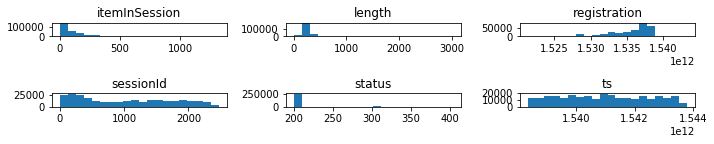

In [15]:
df2_p.hist(figsize = (20,16),bins=20, grid=False, layout=(15, 3))
plt.tight_layout(rect=[0, 0, 0.5, 0.9])
plt.show()

#### Define Churn

In [9]:
### We observe the data with Cancellation Confirmation
df2.filter("page = 'Cancellation Confirmation'").show(2)

+------+---------+---------+------+-------------+--------+------+-----+--------------------+------+--------------------+-------------+---------+----+------+-------------+--------------------+------+
|artist|     auth|firstName|gender|itemInSession|lastName|length|level|            location|method|                page| registration|sessionId|song|status|           ts|           userAgent|userId|
+------+---------+---------+------+-------------+--------+------+-----+--------------------+------+--------------------+-------------+---------+----+------+-------------+--------------------+------+
|  null|Cancelled|   Adriel|     M|          104| Mendoza|  null| paid|  Kansas City, MO-KS|   GET|Cancellation Conf...|1535623466000|      514|null|   200|1538943990000|"Mozilla/5.0 (Mac...|    18|
|  null|Cancelled|    Diego|     M|           56|   Mckee|  null| paid|Phoenix-Mesa-Scot...|   GET|Cancellation Conf...|1537167593000|      540|null|   200|1539033046000|"Mozilla/5.0 (iPh...|    32|
+----

In [10]:
### we count the pages with Cancellation Confirmation

df2.filter("page = 'Cancellation Confirmation'").count()

52

In [11]:
churn_event = udf(lambda x: 1 if x == 'Cancellation Confirmation' else 0, IntegerType())
df2 = df2.withColumn('churn_event',churn_event('page'))
windowval = Window.partitionBy('userId')
df2 = df2.withColumn('churn', max("churn_event").over(windowval))
df2.show(2)

+--------------------+---------+---------+------+-------------+---------+---------+-----+--------------------+------+--------+-------------+---------+--------------------+------+-------------+--------------------+------+-----------+-----+
|              artist|     auth|firstName|gender|itemInSession| lastName|   length|level|            location|method|    page| registration|sessionId|                song|status|           ts|           userAgent|userId|churn_event|churn|
+--------------------+---------+---------+------+-------------+---------+---------+-----+--------------------+------+--------+-------------+---------+--------------------+------+-------------+--------------------+------+-----------+-----+
|Sleeping With Sirens|Logged In| Darianna|     F|            0|Carpenter|202.97098| free|Bridgeport-Stamfo...|   PUT|NextSong|1538016340000|       31|Captain Tyin Knot...|   200|1539003534000|"Mozilla/5.0 (iPh...|100010|          0|    0|
|Francesca Battist...|Logged In| Darianna|  

In [12]:
df2.select(['userId', 'churn']).dropDuplicates().show()


+------+-----+
|userId|churn|
+------+-----+
|100010|    0|
|200002|    0|
|   125|    1|
|   124|    0|
|    51|    1|
|     7|    0|
|    15|    0|
|    54|    1|
|   155|    0|
|100014|    1|
|   132|    0|
|   154|    0|
|   101|    1|
|    11|    0|
|   138|    0|
|300017|    0|
|100021|    1|
|    29|    1|
|    69|    0|
|   112|    0|
+------+-----+
only showing top 20 rows



#### Exploring Data Analysis

### Calculating statistics by hour

In [20]:
##### 1) Calculating Statics by  hour

get_hour = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0). hour)
df2= df2.withColumn("hour", get_hour(df2.ts))
df2.show(5)

+--------------------+---------+---------+------+-------------+---------+---------+-----+--------------------+------+---------+-------------+---------+--------------------+------+-------------+--------------------+------+-----------+-----+----+
|              artist|     auth|firstName|gender|itemInSession| lastName|   length|level|            location|method|     page| registration|sessionId|                song|status|           ts|           userAgent|userId|churn_event|churn|hour|
+--------------------+---------+---------+------+-------------+---------+---------+-----+--------------------+------+---------+-------------+---------+--------------------+------+-------------+--------------------+------+-----------+-----+----+
|Sleeping With Sirens|Logged In| Darianna|     F|            0|Carpenter|202.97098| free|Bridgeport-Stamfo...|   PUT| NextSong|1538016340000|       31|Captain Tyin Knot...|   200|1539003534000|"Mozilla/5.0 (iPh...|100010|          0|    0|  12|
|Francesca Battist..

In [21]:
songs_in_hour = df2.filter(df2.page == "NextSong").groupby(df2.hour).count().orderBy(df2.hour.cast("float"))

In [22]:
songs_in_hour.show()

+----+-----+
|hour|count|
+----+-----+
|   0| 9062|
|   1| 8388|
|   2| 8336|
|   3| 8355|
|   4| 8147|
|   5| 8178|
|   6| 8054|
|   7| 8091|
|   8| 8253|
|   9| 8498|
|  10| 8882|
|  11| 8830|
|  12| 9326|
|  13| 9644|
|  14|10494|
|  15|11354|
|  16|11636|
|  17|11460|
|  18|11124|
|  19|10930|
+----+-----+
only showing top 20 rows



In [23]:
songs_in_hour_pd = songs_in_hour.toPandas()
songs_in_hour_pd.hour = pd.to_numeric(songs_in_hour_pd.hour)

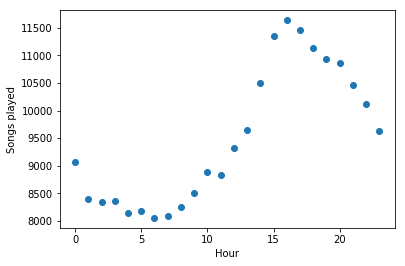

In [24]:
plt.scatter(songs_in_hour_pd["hour"], songs_in_hour_pd["count"])
#plt.xlim(-1, 24);
#plt.ylim(0, 1.2 * max(songs_in_hour_pd["count"]))
plt.xlabel("Hour")
plt.ylabel("Songs played");
plt.show()


##### We observe that the number of songs which are played per hour are increased from the morning until the night. It seems that the graphs shows a periodicity during the day.

### Calculating statistics by gender

In [25]:
df3=df2.dropDuplicates(["userId", "gender"])
df4=df3.groupby(['churn','gender']).count().toPandas()

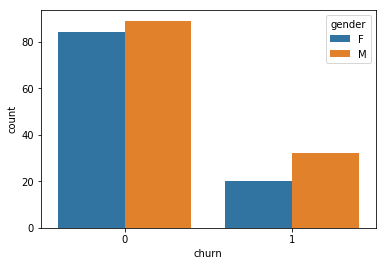

In [26]:
sns.barplot(x='churn', y='count', hue='gender', data=df4)


#### We observe that the majority of the users in each case are males. Especially the users who lead to Cancellation confirmation are  men.

# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

In [27]:
df2.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)
 |-- churn_event: integer (nullable = true)
 |-- churn: integer (nullable = true)
 |-- hour: string (nullable = true)



### As we can see above from the Schema of the dataframe we can extract informations and features from gender itemInSession,level,page,sessionId,status,churn and the hour

In [15]:
df2.select("page").dropDuplicates().sort("page").show()

+--------------------+
|                page|
+--------------------+
|               About|
|          Add Friend|
|     Add to Playlist|
|              Cancel|
|Cancellation Conf...|
|           Downgrade|
|               Error|
|                Help|
|                Home|
|              Logout|
|            NextSong|
|         Roll Advert|
|       Save Settings|
|            Settings|
|    Submit Downgrade|
|      Submit Upgrade|
|         Thumbs Down|
|           Thumbs Up|
|             Upgrade|
+--------------------+



In [13]:
df2.select("level").dropDuplicates().sort("level").show()

+-----+
|level|
+-----+
| free|
| paid|
+-----+



In [14]:
df2.select("gender").dropDuplicates().sort("gender").show()

+------+
|gender|
+------+
|     F|
|     M|
+------+



### We can use the unique values of page in order to estimate the behavior of the users such as  upgrade or  downgrade their submition.

#### Firstly we have to define our features and convert the categorical into numerical features!!!

The features that we will use for our model are:
    
- count_thumpsup: the number of songs  that the users like
    
- count_thumpsdown:the number od songs that the users dislike
    
- count_downgrade: the number of songs that  the users submit downgrade
    
- count_upgrade:the number of songs that the users submit upgrade
- count_advert:the number of advertisments that rolled for each user
- count_playlist:the number of songs that a user adds to the playlist
- level:the level of each user, if the user is free or paid
- gender:the gender distribution of users
- count_friends:the number of friends that each user adds
- count_songs:the number of songs that each user listens
- count_songs_persession:the number of songs that eaxh user listens per session

#### count_thumpsup

In [15]:
f1 = df2.where(df2.page == 'Thumbs Up').groupBy('userId').count().withColumnRenamed('count', 'count_thumpsup')


In [16]:
f1.show()

+------+--------------+
|userId|count_thumpsup|
+------+--------------+
|100010|            17|
|200002|            21|
|    51|           100|
|   124|           171|
|     7|             7|
|    54|           163|
|    15|            81|
|   155|            58|
|   132|            96|
|   154|            11|
|100014|            17|
|   101|            86|
|    11|            40|
|   138|            95|
|300017|           303|
|    29|           154|
|    69|            72|
|100021|            11|
|    42|           166|
|   112|             9|
+------+--------------+
only showing top 20 rows



### count_thumpsdown

In [17]:
f2 = df2.where(df2.page == 'Thumbs Down').groupBy('userId').count().withColumnRenamed('count', 'count_thumpsdown')


In [18]:
f2.show()

+------+----------------+
|userId|count_thumpsdown|
+------+----------------+
|100010|               5|
|200002|               6|
|    51|              21|
|   124|              41|
|     7|               1|
|    15|              14|
|    54|              29|
|   155|               3|
|   132|              17|
|100014|               3|
|   101|              16|
|    11|               9|
|   138|              24|
|300017|              28|
|    29|              22|
|    69|               9|
|100021|               5|
|    42|              25|
|   112|               3|
|    73|               7|
+------+----------------+
only showing top 20 rows



### count_downgrade

In [19]:
f3 = df2.where(df2.page == 'Submit Downgrade').groupBy('userId').count().withColumnRenamed('count', 'count_downgrade')


In [20]:
f3.show()

+------+---------------+
|userId|count_downgrade|
+------+---------------+
|    54|              1|
|    11|              1|
|    30|              1|
|    59|              1|
|    85|              2|
|    35|              2|
|100008|              1|
|100025|              1|
|300002|              1|
|    96|              1|
|   100|              1|
|    61|              2|
|   131|              2|
|   140|              3|
|300004|              1|
|300015|              1|
|    77|              1|
|100009|              1|
|300011|              1|
|100004|              2|
+------+---------------+
only showing top 20 rows



### count_upgrade

In [21]:
f4 = df2.where(df2.page == 'Submit Upgrade').groupBy('userId').count().withColumnRenamed('count', 'count_upgrade')


In [22]:
f4.show()

+------+-------------+
|userId|count_upgrade|
+------+-------------+
|200002|            1|
|    54|            1|
|   155|            1|
|   132|            1|
|   101|            1|
|    11|            2|
|   138|            1|
|    69|            1|
|    29|            1|
|    42|            1|
|    73|            1|
|    87|            1|
|   113|            1|
|    30|            1|
|    59|            2|
|   139|            1|
|    28|            1|
|300018|            1|
|300012|            1|
|    85|            3|
+------+-------------+
only showing top 20 rows



### count_adverts

In [23]:
f5 = df2.where(df2.page == 'Roll Advert').groupBy('userId').count().withColumnRenamed('count', 'count_adverts')


In [24]:
f5.show()

+------+-------------+
|userId|count_adverts|
+------+-------------+
|100010|           52|
|200002|            7|
|   125|            1|
|     7|           16|
|   124|            4|
|    54|           47|
|    15|            1|
|   155|            8|
|   154|           10|
|   132|            2|
|100014|            2|
|   101|            8|
|    11|           39|
|   138|           17|
|300017|           11|
|    29|           22|
|    69|            3|
|100021|           30|
|    42|           10|
|   112|           21|
+------+-------------+
only showing top 20 rows



### count_playlist

In [25]:
f6 = df2.where(df2.page == 'Add to Playlist').groupBy('userId').count().withColumnRenamed('count', 'count_playlist')


In [26]:
f6.show()

+------+--------------+
|userId|count_playlist|
+------+--------------+
|100010|             7|
|200002|             8|
|    51|            52|
|   124|           118|
|     7|             5|
|    15|            59|
|    54|            72|
|   155|            24|
|   132|            38|
|   154|             1|
|100014|             7|
|   101|            61|
|    11|            20|
|   138|            67|
|300017|           113|
|    29|            89|
|    69|            33|
|100021|             7|
|    42|           104|
|   112|             7|
+------+--------------+
only showing top 20 rows



### count_friends

In [27]:
f7= df2.where(df2.page == 'Add Friend').groupBy('userId').count().withColumnRenamed('count', 'count_friends')


In [28]:
f7.show()

+------+-------------+
|userId|count_friends|
+------+-------------+
|100010|            4|
|200002|            4|
|    51|           28|
|   124|           74|
|     7|            1|
|    54|           33|
|    15|           31|
|   155|           11|
|   132|           41|
|   154|            3|
|100014|            6|
|   101|           29|
|    11|            6|
|   138|           41|
|300017|           63|
|    29|           47|
|    69|           12|
|100021|            7|
|    42|           52|
|   112|            7|
+------+-------------+
only showing top 20 rows



### count_songs

In [29]:
f8= df2.select("userId","song").groupBy('userId').count().withColumnRenamed('count', 'count_songs')


In [30]:
f8.show()

+------+-----------+
|userId|count_songs|
+------+-----------+
|100010|        381|
|200002|        474|
|   125|         11|
|    51|       2464|
|   124|       4825|
|     7|        201|
|    54|       3437|
|    15|       2278|
|   155|       1002|
|   132|       2304|
|   154|        118|
|100014|        310|
|   101|       2149|
|    11|        848|
|   138|       2469|
|300017|       4428|
|    29|       3603|
|    69|       1342|
|100021|        319|
|    42|       4257|
+------+-----------+
only showing top 20 rows



### count_persession

In [31]:
### the number of songs that listen each user per session
f9=  df2.where('page == "NextSong"') \
    .groupby(['userId', 'sessionId']) \
    .count() 
    

f9=f9.groupby('userId').avg().withColumnRenamed("avg(count)","count_persession")
f9=f9.select("userId","count_persession")
f9.show()

+------+------------------+
|userId|  count_persession|
+------+------------------+
|100010|39.285714285714285|
|200002|              64.5|
|   125|               8.0|
|    51|             211.1|
|   124|145.67857142857142|
|     7|21.428571428571427|
|    54| 81.17142857142858|
|    15|136.71428571428572|
|   155|136.66666666666666|
|100014|42.833333333333336|
|   132|             120.5|
|   154|              28.0|
|   101|             179.7|
|    11|           40.4375|
|300017|59.540983606557376|
|   138|             138.0|
|    29| 89.05882352941177|
|    69|             125.0|
|100021|              46.0|
|    42| 87.14634146341463|
+------+------------------+
only showing top 20 rows



### level

In [32]:
f10=df2.select('userId', 'level').dropDuplicates() 

In [33]:
level_event = udf(lambda x: 1 if x == 'paid' else 0, IntegerType())
f10 = f10.withColumn('level_event',level_event('level'))

f10=f10.select("userId",col("level_event").alias("level"))
f10.show()

+------+-----+
|userId|level|
+------+-----+
|100021|    0|
|200021|    0|
|200001|    0|
|     6|    0|
|300022|    1|
|   132|    0|
|   112|    0|
|    79|    0|
|200008|    0|
|    16|    1|
|200007|    1|
|300015|    0|
|    39|    0|
|300014|    1|
|    61|    0|
|    56|    1|
|300014|    0|
|   100|    1|
|300024|    1|
|300023|    1|
+------+-----+
only showing top 20 rows



In [54]:
f10.describe().show()

+-------+------------------+------------------+
|summary|            userId|             level|
+-------+------------------+------------------+
|  count|               360|               360|
|   mean| 64780.23888888889|0.4583333333333333|
| stddev|106080.85223362078|0.4989543383465812|
|    min|                10|                 0|
|    max|                99|                 1|
+-------+------------------+------------------+



### gender

In [34]:
f11=df2.select('userId', 'gender').dropDuplicates() 

In [35]:
gender_event = udf(lambda x: 1 if x == 'M' else 0, IntegerType())
f11 = f11.withColumn('gender_event',gender_event('gender'))

f11=f11.select("userId",col("gender_event").alias("gender"))
f11.show()

+------+------+
|userId|gender|
+------+------+
|    44|     0|
|    46|     0|
|    41|     0|
|    72|     0|
|300023|     0|
|    39|     0|
|100010|     0|
|    40|     0|
|    94|     0|
|    35|     0|
|    75|     0|
|   116|     0|
|200001|     1|
|200020|     1|
|100008|     0|
|200015|     1|
|   100|     1|
|100006|     0|
|300005|     0|
|    25|     0|
+------+------+
only showing top 20 rows



In [57]:
f11.describe().show()

+-------+------------------+-------------------+
|summary|            userId|             gender|
+-------+------------------+-------------------+
|  count|               225|                225|
|   mean|65391.013333333336| 0.5377777777777778|
| stddev|105396.47791907165|0.49968243883744773|
|    min|                10|                  0|
|    max|                99|                  1|
+-------+------------------+-------------------+



### We select the churn column and rename it as label as it our label column. We merge all features and the label that we will use into one new frame!!!

In [36]:
f_label = df2.select('userId', col('churn').alias('label')).dropDuplicates() 

f_label.show()

+------+-----+
|userId|label|
+------+-----+
|100010|    0|
|200002|    0|
|   125|    1|
|   124|    0|
|    51|    1|
|     7|    0|
|    15|    0|
|    54|    1|
|   155|    0|
|100014|    1|
|   132|    0|
|   154|    0|
|   101|    1|
|    11|    0|
|   138|    0|
|300017|    0|
|100021|    1|
|    29|    1|
|    69|    0|
|   112|    0|
+------+-----+
only showing top 20 rows



In [59]:
f_label.describe().show()

+-------+------------------+------------------+
|summary|            userId|             label|
+-------+------------------+------------------+
|  count|               225|               225|
|   mean|65391.013333333336|0.2311111111111111|
| stddev|105396.47791907164|0.4224832108996327|
|    min|                10|                 0|
|    max|                99|                 1|
+-------+------------------+------------------+



In [37]:
new_data = f1.join(f2,on=['userId'],how='inner').join(f3,on=['userId'],how="inner").join(f4,on=['userId'],how="inner").join(f5,on=['userId'],how="inner")\
           .join(f6,on=['userId'],how="inner").join(f7,on=['userId'],how="inner").join(f8,on=['userId'],how="inner").join(f9,on=['userId'],how="inner")\
           .join(f10,on=['userId'],how="inner").join(f11,on=['userId'],how="inner").join(f_label,on=['userId'],how="inner").drop('userId').fillna(0)

In [38]:
new_data.show(5)

+--------------+----------------+---------------+-------------+-------------+--------------+-------------+-----------+------------------+-----+------+-----+
|count_thumpsup|count_thumpsdown|count_downgrade|count_upgrade|count_adverts|count_playlist|count_friends|count_songs|  count_persession|level|gender|label|
+--------------+----------------+---------------+-------------+-------------+--------------+-------------+-----------+------------------+-----+------+-----+
|           163|              29|              1|            1|           47|            72|           33|       3437| 81.17142857142858|    1|     0|    1|
|           163|              29|              1|            1|           47|            72|           33|       3437| 81.17142857142858|    0|     0|    1|
|            40|               9|              1|            2|           39|            20|            6|        848|           40.4375|    1|     0|    0|
|            40|               9|              1|         

# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

### Data Preprocessing

#### VectorAssembler

In [39]:
new_data.printSchema()

root
 |-- count_thumpsup: long (nullable = false)
 |-- count_thumpsdown: long (nullable = false)
 |-- count_downgrade: long (nullable = false)
 |-- count_upgrade: long (nullable = false)
 |-- count_adverts: long (nullable = false)
 |-- count_playlist: long (nullable = false)
 |-- count_friends: long (nullable = false)
 |-- count_songs: long (nullable = false)
 |-- count_persession: double (nullable = false)
 |-- level: integer (nullable = true)
 |-- gender: integer (nullable = true)
 |-- label: integer (nullable = true)



In [40]:
feature_columns=['count_thumpsup','count_thumpsdown','count_downgrade','count_upgrade','count_adverts',
                'count_playlist','count_friends','count_songs','count_persession','level','gender']

In [41]:
assembler = VectorAssembler(inputCols=feature_columns, outputCol="NumFeatures")
new_data= assembler.transform(new_data)

In [42]:
new_data.head()

Row(count_thumpsup=163, count_thumpsdown=29, count_downgrade=1, count_upgrade=1, count_adverts=47, count_playlist=72, count_friends=33, count_songs=3437, count_persession=81.17142857142858, level=1, gender=0, label=1, NumFeatures=DenseVector([163.0, 29.0, 1.0, 1.0, 47.0, 72.0, 33.0, 3437.0, 81.1714, 1.0, 0.0]))

#### Scale the Vectors

In [43]:
scaler2 = StandardScaler(inputCol="NumFeatures", outputCol="Features", withStd=True)
scalerModel = scaler2.fit(new_data)
new_data = scalerModel.transform(new_data)

In [44]:
new_data.head()

Row(count_thumpsup=163, count_thumpsdown=29, count_downgrade=1, count_upgrade=1, count_adverts=47, count_playlist=72, count_friends=33, count_songs=3437, count_persession=81.17142857142858, level=1, gender=0, label=1, NumFeatures=DenseVector([163.0, 29.0, 1.0, 1.0, 47.0, 72.0, 33.0, 3437.0, 81.1714, 1.0, 0.0]), Features=DenseVector([1.6221, 1.5548, 1.8059, 1.2479, 1.483, 1.5039, 1.0475, 1.7719, 3.183, 1.9889, 0.0]))

### Data Splitting for Modeling

In [45]:
new_data=new_data.select(['label', 'Features'])
new_data = new_data.selectExpr("label as label", "Features as features")

In [46]:
train, test = new_data.randomSplit([0.7, 0.3], seed=42)


In [47]:
train.printSchema()

root
 |-- label: integer (nullable = true)
 |-- features: vector (nullable = true)



In [48]:
test.printSchema()

root
 |-- label: integer (nullable = true)
 |-- features: vector (nullable = true)



### ML Algorithms

#### Logistic Regression

In [51]:
log_reg =LogisticRegression(maxIter=10)

In [52]:
model_lr=log_reg.fit(train)

In [53]:
results2=model_lr.transform(test)

In [54]:
results2.head()

Row(label=1, features=DenseVector([1.6221, 1.5548, 1.8059, 1.2479, 1.483, 1.5039, 1.0475, 1.7719, 3.183, 0.0, 0.0]), rawPrediction=DenseVector([1.3653, -1.3653]), probability=DenseVector([0.7966, 0.2034]), prediction=0.0)

### Confusion Matrix of the Logistic Regression model

In [55]:
tp = results2.filter("label = 1 and prediction = 1").count()
tn=results2.filter("label = 0 and prediction = 0").count()
fp = results2.filter("label = 0 and prediction = 1").count()
fn = results2.filter("label = 1 and prediction = 0").count()

precision = tp / (tp + fp) 
recall = tp / (tp + fn)
accuracy=(tn+tp)/(tp+tn+fp+fn)
F1 = 2*precision*recall / (precision+recall)
print(precision, recall, F1)

1.0 0.5 0.6666666666666666


In [56]:
print('Evaluation from Logistic Regression:')
print('Accuracy: {}'.format(accuracy))


Evaluation from Logistic Regression:
Accuracy: 0.9230769230769231


### Random Forest

In [49]:
random_forest = RandomForestClassifier()


In [50]:
model_rf=random_forest.fit(train)


In [51]:
results3=model_rf.transform(test)

### Confusion Matrix of the Random Forest model

In [54]:
tp = results3.filter("label = 1 and prediction = 1").count()
tn=results3.filter("label = 0 and prediction = 0").count()
fp = results3.filter("label = 0 and prediction = 1").count()
fn = results3.filter("label = 1 and prediction = 0").count()

precision_rf = tp / (tp + fp) 
recall_rf = tp / (tp + fn)
accuracy_rf=(tn+tp)/(tp+tn+fp+fn)
F1_rf = 2*precision_rf*recall_rf / (precision_rf+recall_rf)
print(precision_rf, recall_rf, F1_rf)

1.0 0.75 0.8571428571428571


In [55]:
print('Evaluation from Random Forest:')
print('Accuracy: {}'.format(accuracy_rf))



Evaluation from Random Forest:
Accuracy: 0.9615384615384616


#### Naive Bayes

In [56]:
nv=NaiveBayes()

In [57]:
model_nv=nv.fit(train)

In [58]:
results4=model_nv.transform(test)

## Confusion Matrix of the Naive Bayes Model

In [59]:
tp = results4.filter("label = 1 and prediction = 1").count()
tn=results4.filter("label = 0 and prediction = 0").count()
fp = results4.filter("label = 0 and prediction = 1").count()
fn = results4.filter("label = 1 and prediction = 0").count()

precision_nv = tp / (tp + fp) 
recall_nv = tp / (tp + fn)
accuracy_nv=(tn+tp)/(tp+tn+fp+fn)
F1_nv= 2*precision_nv*recall_nv / (precision_nv+recall_nv)
print(precision_nv, recall_nv, F1_nv)

1.0 0.5 0.6666666666666666


In [60]:
print('Evaluation from Naive Bayes:')
print('Accuracy: {}'.format(accuracy_nv))


Evaluation from Naive Bayes:
Accuracy: 0.9230769230769231


## Results

We observe that the Random Forest works better than the other two models. It shows higher accuracy compared to Logistic Regression and Naive Bayes model